In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install keras-tuner

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

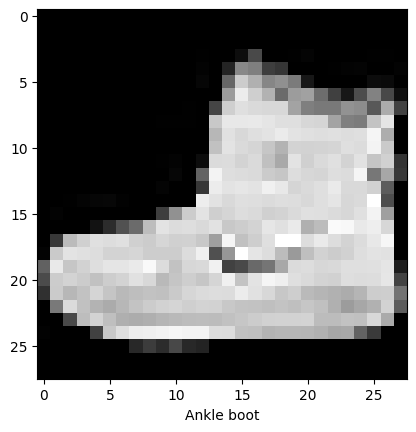

In [5]:
# display the first image
plt.imshow(x_train[0],cmap = 'grey')
plt.xlabel(classes[y_train[0]])
plt.show()

In [6]:
# data scaling
x_train = x_train/255.0
x_test = x_test /255.0

In [7]:
print(x_train.ndim)
print(x_test.ndim)

print(x_train.shape)
print(x_test.shape)
# but the image has to be in 4 dimensions (ie., no.of.images x height x width x layers)

3
3
(60000, 28, 28)
(10000, 28, 28)


In [8]:
# reshaping the data into 4 dimensions i.e: #of images,#rows, #columns, #layers
x_train = x_train.reshape(len(x_train),28,28,1)
x_test = x_test.reshape(len(x_test),28,28,1)

In [9]:
# building the hyper model
def hyper_model(hp):
  model = Sequential([
      Conv2D(filters = hp.Int('conv_1_filter',min_value = 16, max_value = 128,step = 8),
             kernel_size = hp.Choice('conv_1_kernel',values = [3,4,5]),
             activation = 'relu',
             input_shape = (28,28,1)),
      Conv2D(filters = hp.Int('conv_2_filter',min_value = 8, max_value = 64, step = 4),
             kernel_size = hp.Choice('conv_2_kernel',values=[3,4,5]),
             activation = 'relu'),
      MaxPooling2D((2,2)),
      Flatten(),
      Dense(units = hp.Int('dense_1_units',
                           min_value =32, max_value=256, step =4),
            activation  = 'relu'),
      Dense(units=hp.Int('dense_2_units',
                         min_value=32,max_value=128,step = 4),
            activation = 'relu'),
      Dense(10,activation = 'softmax')
  ])

  model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4]))
  ,loss = 'sparse_categorical_crossentropy'
  ,metrics = ['accuracy'])
  return model

In [10]:
tuner_output = RandomSearch(hyper_model,
                            objective = 'val_accuracy',
                            max_trials = 5,
                            project_name = 'Mnist Optimization')

In [11]:
# tuner search
tuner_output.search(x_train,y_train,epochs = 10,validation_split = 0.2, batch_size = 32)

Trial 5 Complete [00h 01m 23s]
val_accuracy: 0.922249972820282

Best val_accuracy So Far: 0.922249972820282
Total elapsed time: 00h 07m 25s


In [12]:
# extracting the best hyperparameters out of alll search
final_model = tuner_output.get_best_models(num_models = 1)[0]
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 48)     │         6,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │       718,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 76)             │         7,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,822 (2.80 MB)

 Trainable params: 734,822 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# fitting the data into the final model
final_model.fit(x_train,y_train,epochs = 15, initial_epoch = 10, validation_split = 0.2)

Epoch 11/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9850 - loss: 0.0406 - val_accuracy: 0.9186 - val_loss: 0.3931
Epoch 12/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9896 - loss: 0.0296 - val_accuracy: 0.9143 - val_loss: 0.4194
Epoch 13/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9914 - loss: 0.0233 - val_accuracy: 0.9214 - val_loss: 0.4242
Epoch 14/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9901 - loss: 0.0275 - val_accuracy: 0.9184 - val_loss: 0.4624
Epoch 15/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9933 - loss: 0.0194 - val_accuracy: 0.9170 - val_loss: 0.4638


In [14]:
final_model.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9154 - loss: 0.5126


[0.5093229413032532, 0.9146000146865845]

In [15]:
y_pred = final_model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [16]:
# index number of the predicted class based on the highest probability
y_class = np.array([np.argmax(ele) for ele in y_pred])

In [17]:
# print the first 5 outputs
print('The actual label for the first 5 images: ',y_test[0:5])
print('The predicted label for the first 5 images: ',y_class[0:5])


The actual label for the first 5 images:  [9 2 1 1 6]
The predicted label for the first 5 images:  [9 2 1 1 6]


In [20]:
# function the validate the random image
def validate_rdm_img():
  rdm_img = random.randint(0,len(x_test))
  plt.imshow(x_test[rdm_img],cmap='grey')
  plt.show()

  print('The actual image is: ',classes[y_test[rdm_img]])
  print('The predicted image is : ',classes[y_class[rdm_img]])
  print('Prediction Probability is: ',round(y_pred[rdm_img][y_class[rdm_img]]*100,2),'%')

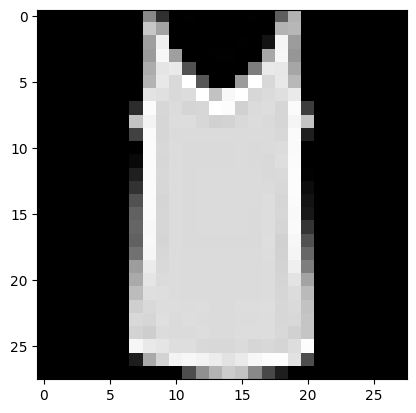

The actual image is:  Shirt
The predicted image is :  Shirt
Prediction Probability is:  98.63 %


In [21]:
validate_rdm_img()

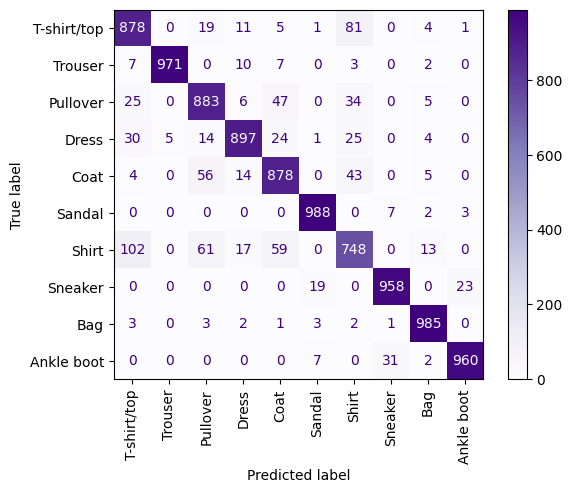

In [22]:
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_class,display_labels = classes,xticks_rotation = 'vertical',cmap = 'Purples')

In [23]:
report = classification_report(y_test, y_class, target_names = classes)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.88      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.85      0.88      0.87      1000
       Dress       0.94      0.90      0.92      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.80      0.75      0.77      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

